# Self-Train NER model

In [1]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm, trange
import ast

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig, get_linear_schedule_with_warmup
from transformers import BertForTokenClassification #　for ner
from torch.optim import AdamW   # ✅ 從 torch 來

from keras.preprocessing.sequence import pad_sequences #2.2.4
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

MAX_LEN = 75
bs = 32

tag_values = ['O',
 'B_person_name',
 'M_person_name',
 'E_person_name',
 'PAD']

tag2idx = { 'O': 0,
           'B_person_name': 1,
           'M_person_name': 2,
           'E_person_name': 3,
           'PAD': 4}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

print(torch.cuda.get_device_name(0))

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer_chinese.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

#　read data 
asia = pd.read_csv('data/亞洲研究院數據集/asia_institute.csv')
asia.words = asia.words.apply(lambda x :ast.literal_eval(x))
asia.tags_encoding = asia.tags_encoding.apply(lambda x :ast.literal_eval(x))

def cut_tag_encoding(words, tags_encoding):
    return tags_encoding[:len(words)]
# 剪裁掉不必要的labels
asia['tags_encoding_cut'] = asia.apply(lambda x :cut_tag_encoding(x.words, x.tags_encoding), axis=1)

# load pretrained bert model 
tokenizer_chinese = BertTokenizer.from_pretrained("bert-base-chinese", do_lower_case=False)
model = BertForTokenClassification.from_pretrained(
    "bert-base-chinese",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)
model.cuda();
# Process Data
#　['因', '有', '关']　to [1728, 3300, 1068]
tokenized_texts = [tokenizer_chinese.convert_tokens_to_ids(txt) for txt in asia['words'].tolist()]
# [1728, 3300, 1068] to [1728, 3300, 1068, ...,    0,    0,    0]
input_ids = pad_sequences(tokenized_texts,
                          maxlen=MAX_LEN, dtype="long", value=0.0, #　MAX_LEN
                          truncating="post", padding="post")
#　 [1728, 3300, 1068, ...,    0,    0,    0] TO [1,1,1,0,0]
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

labels = [[tag2idx.get(l) for l in lab] for lab in asia['tags_encoding_cut'].tolist() ]

tags = pad_sequences(labels,
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
# Train Test split
tr_inputs, val_inputs, tr_tags, val_tags, tr_masks, val_masks = train_test_split(
    input_ids, tags, attention_masks,
    random_state=38,
    test_size=0.1
)

tr_inputs = torch.tensor(tr_inputs, dtype=torch.long)  # 等同 int64
val_inputs = torch.tensor(val_inputs, dtype=torch.long)

tr_tags = torch.tensor(tr_tags, dtype=torch.long)
val_tags = torch.tensor(val_tags, dtype=torch.long)

tr_masks = torch.tensor(tr_masks, dtype=torch.long)
val_masks = torch.tensor(val_masks, dtype=torch.long)

# Dataloader

# Sampler（取樣方式）是什麼？

# Sampler 控制 每次迭代取哪幾筆資料來組 batch。

# RandomSampler (隨機取樣)

# 在一個 epoch 內，會隨機打亂資料的順序，再切成 batch。

# 比如原始資料順序是 [1,2,3,4,5,6,7,8]， 用 batch_size=2 →

# 順序取樣：[(1,2), (3,4), (5,6), (7,8)]

# 隨機取樣：[(5,2), (7,1), (3,8), (6,4)]

# SequentialSampler (順序取樣)

# 按照原始順序切 batch，不打亂。

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)#總資料數45081,batch_size:32,所以共有1409個batch

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

# Model parameter setting
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# num_warmup_steps > 0 → 會先上升，再下降
# num_warmup_steps = 0 → 一開始就最高，然後一路下降

# 「Linear with Warmup」是什麼？

# 學習率曲線長這樣：

# Warmup 階段（前 num_warmup_steps 次更新）：

# 學習率從 0 緩慢增加到預設的 lr (這裡是 3e-5)。

# 好處：避免一開始就用太大 lr，導致模型發散。

# 線性下降階段（之後直到 total_steps 結束）：

# 學習率會 線性遞減，最後趨近於 0。

# 好處：後期學習率小，模型會更穩定地收斂。
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


NVIDIA GeForce RTX 4070 SUPER


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
# Model train
from seqeval.metrics import f1_score, accuracy_score
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    # 轉換成 list of list (去掉 PAD)
    valid_tags = [
        [tag_values[l_i] for l_i in l if tag_values[l_i] != "PAD"]
        for l in true_labels
    ]
    
    pred_tags = [
        [tag_values[p_i] for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
        for p, l in zip(predictions, true_labels)
    ]
    
    print("Validation Accuracy: {:.4f}".format(accuracy_score(valid_tags, pred_tags)))
    print("Validation F1-Score: {:.4f}".format(f1_score(valid_tags, pred_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.013628207267533622
Validation loss: 0.0022623164462810606


Epoch:  33%|███▎      | 1/3 [02:55<05:51, 175.86s/it]

Validation Accuracy: 0.9968
Validation F1-Score: 0.9533

Average train loss: 0.0015930614601421228


Epoch:  67%|██████▋   | 2/3 [05:48<02:54, 174.19s/it]

Validation loss: 0.0020924194560874333
Validation Accuracy: 0.9977
Validation F1-Score: 0.9680

Average train loss: 0.0006898482534502845
Validation loss: 0.0019983433742877164
Validation Accuracy: 0.9981
Validation F1-Score: 0.9722



Epoch: 100%|██████████| 3/3 [08:50<00:00, 176.73s/it]


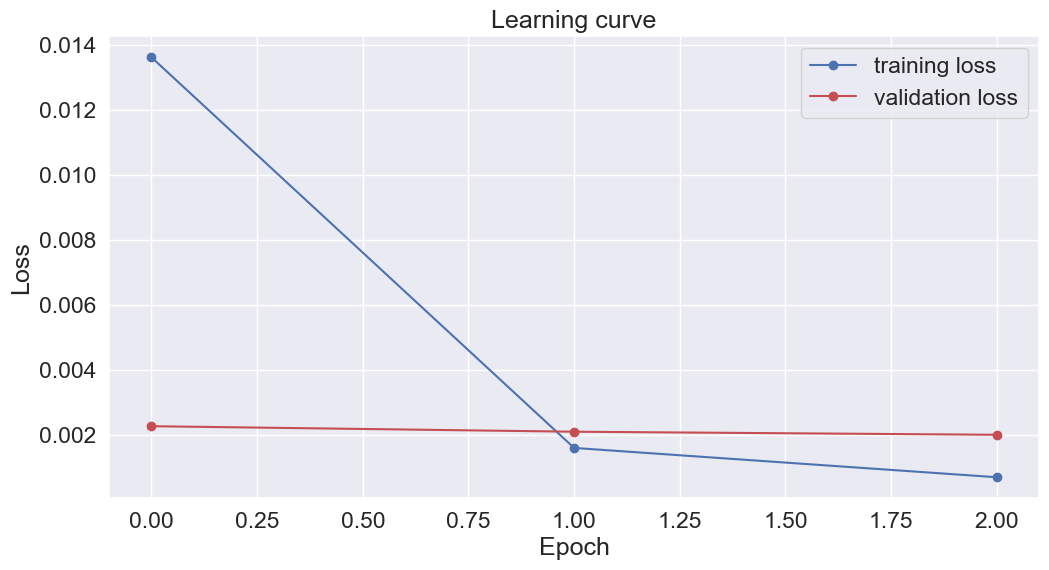

In [3]:
# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import os 


# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# save model
PATH = os.getcwd()+str('/model/ner_model_weights.pth')
torch.save(model.state_dict(), PATH)


# NER model predict

In [9]:
import torch
import os
from transformers import BertTokenizer, BertForTokenClassification
from keras.preprocessing.sequence import pad_sequences

# tag 對應表（要跟訓練時一樣）
tag_values = ['O', 'B_person_name', 'M_person_name', 'E_person_name', 'PAD']
tag2idx = {tag: idx for idx, tag in enumerate(tag_values)}

# 初始化模型與 tokenizer（只需執行一次）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForTokenClassification.from_pretrained(
    "bert-base-chinese",
    num_labels=len(tag2idx),
    output_attentions=False,
    output_hidden_states=False
)

# 載入權重
PATH = os.getcwd() + '/model/ner_model_weights.pth'
model.load_state_dict(torch.load(PATH, map_location=device))
model.to(device)
model.eval()

tokenizer_chinese = BertTokenizer.from_pretrained("bert-base-chinese", do_lower_case=False)


def extract_names(sentence, max_len=75):
    """輸入句子，輸出辨識到的人名 list"""
    
    # tokenize
    tokens = tokenizer_chinese.tokenize(sentence)
    input_ids = tokenizer_chinese.convert_tokens_to_ids(tokens)

    # pad
    input_ids = pad_sequences([input_ids],
                              maxlen=max_len, dtype="long", value=0,
                              truncating="post", padding="post")

    attention_masks = [[float(i != 0.0) for i in seq] for seq in input_ids]

    # tensor
    input_ids = torch.tensor(input_ids).to(device)
    attention_masks = torch.tensor(attention_masks).to(device)

    # 預測
    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)

    logits = outputs[0]
    predictions = torch.argmax(logits, dim=2).cpu().numpy()

    pred_tags = [tag_values[p] for p in predictions[0]][:len(tokens)]

    # 根據 B/M/E 組合名字
    names = []
    current_name = []
    for token, label in zip(tokens, pred_tags):
        if label == "B_person_name":
            current_name = [token]
        elif label == "M_person_name":
            if current_name:  # 中間詞
                current_name.append(token)
        elif label == "E_person_name":
            if current_name:  # 收尾
                current_name.append(token)
                names.append("".join(current_name))
                current_name = []
        else:
            current_name = []  # 遇到 O 或 PAD 就清空

    return names


# 測試
test_sentence = '''中華統一促進黨總裁「白狼」張安樂及其子張瑋，
遭控收受政治獻金卻未按規定申報，還涉替張瑋成立的「華夏大地旅行社」逃漏稅，掏空兩千多萬元公司資產'''

print(extract_names(test_sentence))
# 預期輸出: ['張安樂', '張瑋']


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['張安樂', '張瑋', '張瑋']


In [28]:
test_sentence = '''今天早上的部會抽籤，讓我很緊張，還好看到的是游騰林跟燊磊一齊出現在中獎名單上，真是阿彌陀佛'''

print(extract_names(test_sentence))

['游騰林', '燊磊']


In [29]:
test_sentence = '''夜店小王子家賢本月的KPI是載實習生妹妹下班，真的鬼'''

print(extract_names(test_sentence))

['家賢']


In [ ]:
read data to DataLoader

setup model & config 

